In [1]:
import pandas as pd
import numpy as np
from py2neo import Node, Graph, Relationship
from neo4j import GraphDatabase, basic_auth

from keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image

In [2]:
uri = 'bolt://localhost:7687'
user = 'neo4j'
pwd = '1234'

graph = Graph(uri, auth=('neo4j', pwd))
driver = GraphDatabase.driver(uri, auth = basic_auth(user,pwd))

In [3]:
graph.run('Match (n) DETACH DELETE n')

(No data)

In [4]:
# use the comment line if setting up database for the first time
# graph.run('CREATE CONSTRAINT n10s_unique_uri ON (r:Resource) ASSERT r.uri IS UNIQUE;')

In [5]:
graph.run('call n10s.graphconfig.init( {  handleMultival: "ARRAY" });')

param,value
handleVocabUris,SHORTEN
handleMultival,ARRAY
handleRDFTypes,LABELS


In [6]:
graph.run('CALL n10s.rdf.import.fetch("file:///D:\RMBI_MMKG_data\FB15K\FB15K_EntityTriples_Final.nt","N-Triples");')

terminationStatus,triplesLoaded,triplesParsed,namespaces,extraInfo,callParams
OK,592213,592213,{ns0: 'http://rdf.freebase.com/ns/'},,{}


In [7]:
graph.run('MATCH (n) RETURN count(*);')

count(*)
14953


In [8]:
ResNet = ResNet50(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
for layer in ResNet.layers:
    layer.trainable = False
ResNet = Model(inputs=ResNet.inputs, outputs=ResNet.layers[-2].output)
ResNet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [9]:
img_des = pd.read_csv('D:\RMBI_MMKG_data\img_des.csv')
img_des

,LabelName,name,description
0,/m/027rn,Dominican Republic,The Dominican Republic is a country located on...
1,/m/017dcd,Mighty Morphin Power Rangers,Mighty Morphin Power Rangers is an American su...
2,/m/01sl1q,Michelle Rodriguez,Mayte Michelle Rodriguez is an American actres...
3,/m/0cnk2q,Australia national football team,The Australia men's national soccer team repre...
4,/m/02_j1w,Defender,"In the sport of association football, a defend..."
...,...,...,...
14179,/m/0dlj8q2,Le Monde's 100 Books of the Century,The 100 Books of the Century is a list of the ...
14180,/m/05zp8,Palace,"A palace is a grand residence, especially a ro..."
14181,/m/024030,Padma Vibhushan,The Padma Vibhushan is the second-highest civi...
14182,/m/02y_9cf,Ethiopian Empire,"The Ethiopian Empire, also formerly known by t..."


In [10]:
x_img = []
img_name = []
mid = []
import os

for i in range(100):
    path_of_the_directory = os.path.join('D:\RMBI_MMKG_data\Bulk-Bing-Image-downloader', img_des['name'][i])
    ext = ('.jpg')
    for path, dirc, files in os.walk(path_of_the_directory):
        for name in files:
            if name.endswith(ext):
                
                try:
                    img_path = os.path.join(path, name)               
                    img = image.load_img(img_path, target_size=(224, 224))
                    img = image.img_to_array(img)
                
                    x_img.append(img)
                    img_name.append(name)
                    mid.append(img_des['LabelName'][i])
                except:
                    print(img_path)

C:\Users\Alex\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


In [11]:
x_img = np.array(x_img)

In [12]:
x_img = x_img / 255.0

In [13]:
img_emb = ResNet.predict(x_img)
img_emb

array([[0.       , 0.       , 0.       , ..., 1.8741094, 0.       ,
        0.       ],
       [0.       , 0.       , 0.0262013, ..., 2.37399  , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 2.0955906, 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 2.1073952, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 2.0765061, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 2.534463 , 0.       ,
        0.       ]], dtype=float32)

In [14]:
img_emb.shape

(870, 2048)

In [15]:
img_emb = img_emb.tolist()

In [17]:
len(img_emb)

870

In [30]:
statements = ""

for i in range(len(img_emb)):
    statement = "MERGE (img_%d:Image {mid: '%s', name: '%s'}) SET img_%d.embedding = %s \n" % (i, mid[i], img_name[i], i, img_emb[i])
    statements += statement

In [32]:
session = driver.session()

In [33]:
trx = session.begin_transaction()

In [34]:
trx.run(statements)
trx.commit()

'FB:kcwQowmIKoyLQXmJ4+4Jlm1bvckF+ZA='

In [36]:
re = graph.run('Match (n:Image) RETURN count(*)')
re.data()

[{'count(*)': 870}]

In [38]:
re = graph.run('Match (n:Image) RETURN n.mid, n.name LIMIT 3')
re.data()

[{'n.mid': '/m/027rn', 'n.name': 'img_1.jpg'},
 {'n.mid': '/m/027rn', 'n.name': 'img_2.jpg'},
 {'n.mid': '/m/027rn', 'n.name': 'img_3.jpg'}]

In [41]:
re = graph.run('Match (img1:Image) Match (img2:Image) WHERE img1.mid <> img2.mid RETURN img1.mid, img2.mid, img1.name, img2.name, gds.similarity.euclideanDistance(img1.embedding,img2.embedding) as dist ORDER BY dist ASC LIMIT 5')
re.data()

[{'img1.mid': '/m/01br2w',
  'img2.mid': '/m/02681vq',
  'img1.name': 'img_609.jpg',
  'img2.name': 'img_229.jpg',
  'dist': 0.47399039625403433},
 {'img1.mid': '/m/02681vq',
  'img2.mid': '/m/01br2w',
  'img1.name': 'img_229.jpg',
  'img2.name': 'img_609.jpg',
  'dist': 0.47399039625403433},
 {'img1.mid': '/m/0sxg4',
  'img2.mid': '/m/04yywz',
  'img1.name': 'img_558.jpg',
  'img2.name': 'img_651.jpg',
  'dist': 0.5182335975995319},
 {'img1.mid': '/m/04yywz',
  'img2.mid': '/m/0sxg4',
  'img1.name': 'img_651.jpg',
  'img2.name': 'img_558.jpg',
  'dist': 0.5182335975995319},
 {'img1.mid': '/m/04yywz',
  'img2.mid': '/m/01k7d9',
  'img1.name': 'img_651.jpg',
  'img2.name': 'img_662.jpg',
  'dist': 0.5191474567680664}]

In [55]:
def mid_to_name(a,df):
    return df[df.iloc[:,0]==a].iloc[0,1]

In [58]:
mid_to_name('/m/027rn',img_des)

'Dominican Republic'

Burt Young


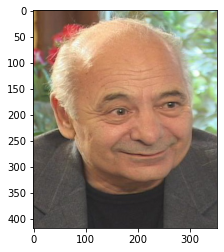

Ray Walston


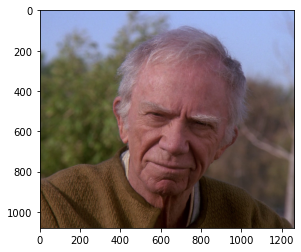

In [69]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print(mid_to_name('/m/04yywz',img_des))
path = 'D:\\RMBI_MMKG_data\\Bulk-Bing-Image-downloader\\' + mid_to_name('/m/04yywz',img_des) + '\\img_651.jpg'
img = mpimg.imread(path)
imgplot = plt.imshow(img)
plt.show()

print(mid_to_name('/m/01k7d9',img_des))
path = 'D:\\RMBI_MMKG_data\\Bulk-Bing-Image-downloader\\' + mid_to_name('/m/01k7d9',img_des) + '\\img_662.jpg'
img = mpimg.imread(path)
imgplot = plt.imshow(img)
plt.show()